In [1]:
#import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
from collections import Counter
from mdtraj.core import element as elem
import os

In [2]:
def process_data(fn) :
    fi = open(fn,'r')    
    for i in range(8) : fi.readline()
    
    raw_coords = []
    read = True
    while read: 
        line = fi.readline().split()
        try: 
            if len(line[0]) > 0 : raw_coords.append(line)
        except : read = False
    raw_connectivity = []
    read = True
    while read: 
        line = fi.readline().split()
        try: 
            if len(line[0]) > 0 : raw_connectivity.append(line)
        except : read = False
    fi.close()    
    
    _H_names = []
    _H_pos = []
    _H_ind = []
    _all_names = []
    _all_pos = []
    for icoord, coord in enumerate(raw_coords) :
        if coord[-1] == 'H' :
            _H_names.append(coord[0])
            _H_pos.append([float(coord[2]),float(coord[3]),float(coord[4])])        
            _H_ind.append(icoord)
        _all_names.append(coord[0])
        _all_pos.append([float(coord[2]),float(coord[3]),float(coord[4])])    
    _connectivity = {}
    for ind in _H_ind : _connectivity[ind] = [ int(cind) - 1 for cind in raw_connectivity[ind][1::2] ]    
    return _H_names, _H_pos, _H_ind, _all_names, _all_pos, _connectivity

In [3]:
def get_H_CVs() :
    # bonds within the high level
    _bonds = []
    for icon in connectivity :
        for ind in connectivity[icon] :
            if ind > icon and ind in H_ind: _bonds.append([icon,ind])  
    # angles within the high level
    _angles = []
    for icon in connectivity :
        for iind in range(len(connectivity[icon])) :
            for jind in range(iind+1,len(connectivity[icon])) :
                if connectivity[icon][iind] in H_ind and connectivity[icon][jind] in H_ind : 
                    _angles.append([connectivity[icon][iind], icon, connectivity[icon][jind]])
    # dihedrals within the high level
    _dihedrals = []
    for icon in connectivity :
        for ind in connectivity[icon] :
            if ind > icon and ind in H_ind : 
                for k in connectivity[icon] :
                    if k != ind and k in H_ind:
                        for l in connectivity[ind] :
                            if l != icon and l in H_ind :
                                _dihedrals.append([k, icon, ind, l]) 
    return _bonds, _angles, _dihedrals

In [4]:
def create_mdtraj_object(_all_names, _all_pos):
    topo_new = md.Topology()
    chain = topo_new.add_chain()
    res = topo_new.add_residue('mol', chain)
    atom_counter = Counter()
    
    for at in _all_names :
        atom_number = atom_counter[at] # atom index
        if   at[0] == 'C' : element = elem.carbon # Get the atom element
        elif at[0] == 'H' : element = elem.hydrogen
        elif at[0] == 'N' : element = elem.nitrogen
        elif at[0] == 'O' : element = elem.oxygen
        elif at[0] == 'S' : element = elem.sulfur    
        topo_new.add_atom(name=at+str(atom_number),
                     element=element,
                     residue=res,
                     serial=atom_number) # Add everything to the topology
        atom_counter.update(at) # Update the atom counter
    
    return md.Trajectory(xyz=np.array(_all_pos), topology=topo_new)

In [5]:
def do_CV_computation(t,_bonds,_angles,_dihedrals):
    return md.compute_distances(t,_bonds), 180/np.pi*md.compute_angles(t,_angles), 180/np.pi*md.compute_dihedrals(t,_dihedrals)

In [6]:
def process_elongated_side(S_string,C_string) :
# determine the CVs pertaining to the "elongated" moiety; THIS CVS WILL BE MARKED WITH *
# now done for sy-ca bonds. adaptation might be needed for other bond types!
# return elongated_bonds, elongated_angles, elongated_dihedrals

    # identify S :
    for iname in range(len(H_names)) : 
        if H_names[iname][:4] == S_string : S_ind = H_ind[iname] 
    # identify C participating in the elongated sy-ca bond        
    C_long_bond = 0.1
    for icon in connectivity[S_ind] : 
        connection_name = H_names[np.where(np.array(H_ind) == icon)[0][0]] # find the name of its connecting atoms
        if connection_name[:4] == C_string : 
            if icon > S_ind : S_C_bond = [S_ind,icon]
            else : S_C_bond = [icon,S_ind]
            for ibond, bond in enumerate(bonds) :
                if S_ind in bond and icon in bond : 
                    if computed_bonds[0][ibond] > C_long_bond :
                        C_long_ind = icon 
                        C_long_bond_ind = bond
                        C_long_bond = computed_bonds[0][ibond]
                        
    # identify atoms in the elongated phenyl group and the corresponding dihedrals  
    _elongated_dihedrals = []
    elongated_indices = []
    for dih in dihedrals :
        if C_long_ind in dih and not S_ind in dih :
            _elongated_dihedrals.append(dih)
            elongated_indices += dih
    elongated_indices = np.unique(elongated_indices)
    # amend elongated_dihedrals with dihedrals: * - C_long_ind - S_ind - O AND * - * - C_long_ind - S_ind
    for dih in dihedrals :
        if (dih[1] == C_long_ind and dih[2] == S_ind) or\
           (dih[2] == C_long_ind and dih[1] == S_ind) or\
           (dih[2] == C_long_ind and dih[3] == S_ind and len(np.intersect1d(dih, elongated_indices)) == 3) or\
           (dih[1] == C_long_ind and dih[0] == S_ind and len(np.intersect1d(dih, elongated_indices)) == 3):
            _elongated_dihedrals.append(dih)
    # add dihedrals defined for all elongated_indices without S_ind : extend elongated_dihedrals beyond the phenyl group
    for dih in dihedrals :
        if (not S_ind in dih) and len(np.intersect1d(dih, elongated_indices)) > 0 :
            _elongated_dihedrals.append(dih)
    
    _elongated_angles = []
    for angle in angles :
        if (not S_ind in angle) and len(np.intersect1d(angle, elongated_indices)) > 0 :
            _elongated_angles.append(angle)
        elif S_ind in angle and C_long_ind in angle : _elongated_angles.append(angle)
             #(angle[1] == C_long_ind and angle[2] == S_ind and len(np.intersect1d(dih, elongated_indices)) == 2) or\
             #(angle[2] == C_long_ind and angle[1] == S_ind and len(np.intersect1d(dih, elongated_indices)) == 2) :
            #_elongated_angles.append(angle)
    
    _elongated_bonds = []
    for bond in bonds :
        if (not S_ind in bond) and len(np.intersect1d(bond, elongated_indices)) > 0 :
            _elongated_bonds.append(bond)
        elif S_ind in bond and C_long_ind in bond : _elongated_bonds.append(bond)
            
    return _elongated_bonds, _elongated_angles, _elongated_dihedrals

In [7]:
def update_computed_CVs(_computed_bond_types,_computed_angle_types,_computed_dihedral_types, _all_dat, _broken) :
    new_entry = {}
    new_entry['broken'] = _broken
    # update bonds
    for bond, val in zip(bonds, computed_bonds[0]) :
        if bond not in elongated_bonds :
            if all_names[bond[0]] < all_names[bond[1]] : bond_tag = all_names[bond[0]]+'_'+all_names[bond[1]]
            else : bond_tag= all_names[bond[1]]+'_'+all_names[bond[0]]
        else:
            if all_names[bond[0]] < all_names[bond[1]] : bond_tag = "*"+all_names[bond[0]]+'_'+all_names[bond[1]]
            else : bond_tag= "*"+all_names[bond[1]]+'_'+all_names[bond[0]]
        if   bond_tag  in _computed_bond_types : _computed_bond_types[bond_tag].append(val)
        else : _computed_bond_types[bond_tag] = [val]
        new_entry[bond_tag] = val    
            
    # update angles
    for angle, val in zip(angles, computed_angles[0]) :
        if angle not in elongated_angles :
            if all_names[angle[0]] < all_names[angle[2]] : ang_tag = all_names[angle[0]]+'_'+all_names[angle[1]]+'_'+all_names[angle[2]]
            else : ang_tag= all_names[angle[2]]+'_'+all_names[angle[1]]+'_'+all_names[angle[0]]
        else:
            if all_names[angle[0]] < all_names[angle[2]] : ang_tag = "*"+all_names[angle[0]]+'_'+all_names[angle[1]]+'_'+all_names[angle[2]]
            else : ang_tag= "*"+all_names[angle[2]]+'_'+all_names[angle[1]]+'_'+all_names[angle[0]]
        if   ang_tag  in _computed_angle_types : _computed_angle_types[ang_tag].append(val)
        else : _computed_angle_types[ang_tag] = [val]
        new_entry[ang_tag] = val

    #update dihedrals
    for dih, val in zip(dihedrals, computed_dihedrals[0]) :
        if dih not in elongated_dihedrals :
            if all_names[dih[0]] < all_names[dih[3]] : dih_tag = all_names[dih[0]]+'_'+all_names[dih[1]]+'_'+all_names[dih[2]]+'_'+all_names[dih[3]]
            else : dih_tag= all_names[dih[3]]+'_'+all_names[dih[2]]+'_'+all_names[dih[1]]+'_'+all_names[dih[0]]
        else:
            if all_names[dih[0]] < all_names[dih[3]] : dih_tag = "*"+all_names[dih[0]]+'_'+all_names[dih[1]]+'_'+all_names[dih[2]]+'_'+all_names[dih[3]]
            else : dih_tag= "*"+all_names[dih[3]]+'_'+all_names[dih[2]]+'_'+all_names[dih[1]]+'_'+all_names[dih[0]]
        if   dih_tag  in _computed_dihedral_types : _computed_dihedral_types[dih_tag].append(val)
        else : _computed_dihedral_types[dih_tag] = [val]    
        new_entry[dih_tag] = val
    _all_dat.append(new_entry)

In [8]:
def select_files(nm) :
    _broken = []
    _not_broken = []
    for _dd2 in dir_list :
        for _dd1 in os.listdir(root+_dd2+'/broken/') :
            if _dd1 != '.DS_Store' :
                try : 
                    if os.listdir(root+_dd2+'/broken/'+_dd1+'/')[0] == nm :
                        _broken.append(root+_dd2+'/broken/'+_dd1+'/'+nm)
                except : print('failed to list: broken',root+_dd2+'/broken/'+_dd1+'/'+nm)
        for _dd1 in os.listdir(root+_dd2+'/not_broken/') :
            if _dd1 != '.DS_Store' :
                try: 
                    if os.listdir(root+_dd2+'/not_broken/'+_dd1+'/')[0] == nm :
                        _not_broken.append(root+_dd2+'/not_broken/'+_dd1+'/'+nm)
                except : print('failed to list not broken',root+_dd2+'/broken/'+_dd1+'/'+nm)
    return _broken, _not_broken

In [9]:
def compute_information_in_cv(_cv) :
    tmp_dat = []
    num_occur = 0
    for td in all_data :
        if _cv in td and td['*C-caj--0.0415_S-syj-0.9724'] < 3.0: # remove outlier
            num_occur += 1
            tmp_dat.append({_cv : td[_cv], 'broken' : td['broken']})
    if num_occur < 100 : # complain if cv occurs too infrequently in sample
        #print('Too few occurrences of', _cv, ':', num_occur) 
        return None
    else :
        mincv = np.min([ td[_cv] for td in tmp_dat])
        maxcv = np.max([ td[_cv] for td in tmp_dat])
        d_cv = (maxcv-mincv)/nbins
        edges = [ mincv + d_cv*ibin for ibin in range(nbins+1) ]
        vals = [ [] for ibin in range(nbins)]
        for td in tmp_dat :
            ind = int((td[_cv]-mincv)/d_cv)
            if ind > nbins-1 : ind = nbins-1
            vals[ind].append(td)
        # prune histogram if too few elements are in a bin
        numval = [ len(val) for val in vals ]
        while np.min(numval) < thrshld :
            min_ind = np.where(numval == np.min(numval))[0][0]
            if min_ind == 0 : merge_ind = min_ind + 1
            elif min_ind == len(numval)-1 : merge_ind = min_ind - 1
            else: 
                if numval[min_ind-1] > numval[min_ind+1] : merge_ind = min_ind + 1
                else : merge_ind = min_ind - 1
            vals[merge_ind] += vals[min_ind]
            vals.pop(min_ind)
            if merge_ind > min_ind : edges.pop(merge_ind)
            else : edges.pop(min_ind)
            numval = [ len(val) for val in vals ]
        
        p_B = []
        p_i = []
        for ival, val in enumerate(vals) : 
            _pb = 0
            for td in val :
                if td['broken'] : _pb += 1
            if not (_pb == 0 or _pb == numval[ival]) :
                p_B.append(float(_pb/numval[ival]))   
                p_i.append(numval[ival]/np.sum(numval))
        p_B = np.array(p_B)
        p_i = np.array(p_i)
        return Info_B_tot - np.dot(np.nan_to_num(-np.array(p_B)*np.log(p_B)-np.array(1-p_B)*np.log(1-p_B)),p_i)

#  MAIN STARTS

In [10]:
dir_list = ['new_strain_test', 'new_strain_test_2', 'new_strain_test_3', '241102-all']
root = '/Users/gyorgy/Downloads/bond_breakage/oniom_results/'
all_data = []

broken_list, not_broken_list = select_files('bond1.com')

###################
# BROKEN ANALYSIS #
###################

computed_bond_types_B = {}
computed_angle_types_B = {}
computed_dihedral_types_B = {}

for fname in broken_list : 
    H_names, H_pos, H_ind, all_names, all_pos, connectivity = process_data(fname)
    bonds, angles, dihedrals = get_H_CVs()
    t_new = create_mdtraj_object(all_names, all_pos)
    computed_bonds, computed_angles, computed_dihedrals = do_CV_computation(t_new,bonds,angles,dihedrals) 
    elongated_bonds, elongated_angles, elongated_dihedrals = process_elongated_side("S-sy","C-ca")
    update_computed_CVs(computed_bond_types_B,computed_angle_types_B,computed_dihedral_types_B,all_data,True)

#######################
# NOT BROKEN ANALYSIS #
#######################

computed_bond_types_NB = {}
computed_angle_types_NB = {}
computed_dihedral_types_NB = {}

for fname in not_broken_list :
    H_names, H_pos, H_ind, all_names, all_pos, connectivity = process_data(fname)
    bonds, angles, dihedrals = get_H_CVs()
    t_new = create_mdtraj_object(all_names, all_pos)
    computed_bonds, computed_angles, computed_dihedrals = do_CV_computation(t_new,bonds,angles,dihedrals) 
    elongated_bonds, elongated_angles, elongated_dihedrals = process_elongated_side("S-sy","C-ca")
    update_computed_CVs(computed_bond_types_NB,computed_angle_types_NB,computed_dihedral_types_NB,all_data,False)
    

failed to list: broken /Users/gyorgy/Downloads/bond_breakage/oniom_results/241102-all/broken/50/bond1.com
failed to list: broken /Users/gyorgy/Downloads/bond_breakage/oniom_results/241102-all/broken/51/bond1.com


# Analyze CVs

In [11]:
keys = []
for td in all_data : keys += list(td.keys())
all_CVs = np.unique(keys)

prob_B = float(len([ rec for rec in all_data if rec['broken'] ]) / len(all_data))
Info_B_tot = (-prob_B*np.log(prob_B) -(1-prob_B)*np.log(1-prob_B)) / np.log(2)

nbins = 30 # compute a histogram of all CVs with this many bins
thrshld = 20 # merge neighboring bins until there is at least this many points in a bin

information_content = {}

for cv in all_CVs :
    if cv != 'broken' :
        info = compute_information_in_cv(cv)
        if info is not None : information_content[cv] = info

info_sorted = list(sorted(information_content.items(), key=lambda item: item[1]))

The spike corresponds to *C-caj--0.0415_S-syj-0.9724 0.5445723607300971


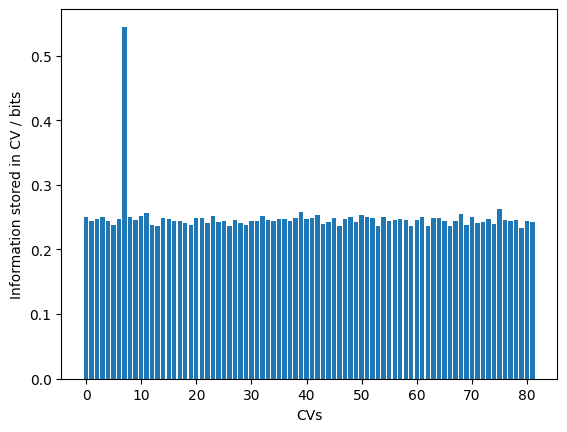

In [12]:
plt.bar(np.arange(len(information_content)),list(information_content.values()))
plt.ylabel("Information stored in CV / bits")
plt.xlabel("CVs")

print('The spike corresponds to *C-caj--0.0415_S-syj-0.9724',information_content['*C-caj--0.0415_S-syj-0.9724'])

In [13]:
# potentially interesting CVs:

print(information_content['*C-caj--0.0415_S-syj-0.9724'])
print(information_content['C-caj--0.0415_S-syj-0.9724']) 
print(information_content['*C-caj--0.0415_S-syj-0.9724_O-oj--0.5633'])
print(information_content['C-caj--0.0415_S-syj-0.9724_O-oj--0.5633'])
print(information_content['*C-caj--0.0415_S-syj-0.9724_C-caj--0.0415'])

0.5445723607300971
0.2496562524609064
0.25228716147119534
0.25273425560018714
0.2502931219924177


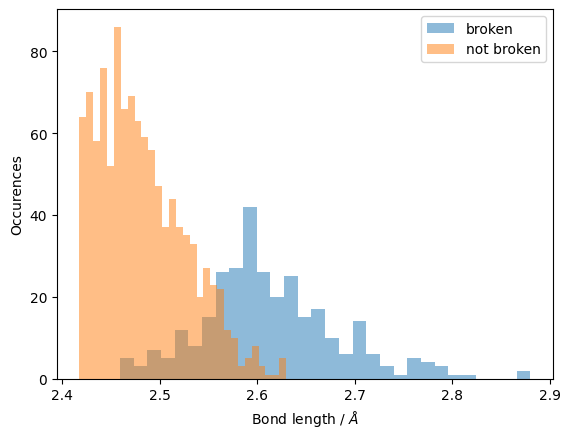

In [14]:
cv = '*C-caj--0.0415_S-syj-0.9724'
plt.hist([ td[cv] for td in all_data if td['broken'] and td[cv] < 3.],density=False,bins=nbins,alpha=0.5,label='broken')
plt.hist([ td[cv] for td in all_data if not td['broken'] and td[cv] < 3.],density=False,bins=nbins,alpha=0.5,label='not broken')
#plt.hist([ td[cv] for td in tmp_dat],density=False,alpha=0.5, bins=20)
plt.ylabel("Occurences")
plt.xlabel("Bond length / $\AA$")
plt.legend()